In [2]:
# ============================================================
# Install dependencies (silent)
# ============================================================
!pip install -q qiskit qiskit_aer qiskit_ibm_runtime


# ============================================================
# Imports
# ============================================================
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
import matplotlib.pyplot as plt

# ============================================================
# Utility headers
# ============================================================
def h1(title):
    print("\n" + "="*len(title))
    print(title)
    print("="*len(title))

def h2(title):
    print("\n" + title)
    print("-"*len(title))

# ============================================================
# Oracle
# ============================================================
def oracle(qc, n, marked_state):
    """
    Oracle: flips the amplitude of the marked state.
    Uses multi-controlled X (mcx).
    """
    for i, bit in enumerate(marked_state):
        if bit == "0":
            qc.x(i)
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1)
    qc.h(n - 1)
    for i, bit in enumerate(marked_state):
        if bit == "0":
            qc.x(i)

# ============================================================
# Diffuser (Inversion about the mean)
# ============================================================
def diffuser(qc, n):
    """Implements Grover's diffuser."""
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1)
    qc.h(n - 1)
    qc.x(range(n))
    qc.h(range(n))

# ============================================================
# Grover’s Search Circuit Builder
# ============================================================
def grover_search(marked_state, iterations=1):
    """
    Builds Grover’s algorithm circuit for the given marked state.
    iterations: number of times oracle+diffuser are applied.
    """
    n = len(marked_state)
    qc = QuantumCircuit(n, n)

    # Step 1: Initialize superposition
    qc.h(range(n))

    # Step 2: Apply Grover iterations
    for _ in range(iterations):
        oracle(qc, n, marked_state)
        diffuser(qc, n)

    # Step 3: Measure
    qc.measure(range(n), range(n))
    return qc

# ============================================================
# Run on Ideal Simulator
# ============================================================
def run_grover(qc, title="Ideal Simulation"):
    simulator = AerSimulator()
    compiled = transpile(qc, simulator)
    result = simulator.run(compiled, shots=1024).result()
    counts = result.get_counts()
    h2(title)
    plot_histogram(counts)
    plt.show()
    print("Counts:", counts)
    return counts

# ============================================================
# Add Noise Model
# ============================================================
def create_noise_model():
    noise = NoiseModel()
    one_q_error = depolarizing_error(0.02, 1)
    two_q_error = depolarizing_error(0.05, 2)
    noise.add_all_qubit_quantum_error(one_q_error, ['h', 'x', 'u1', 'u2', 'u3'])
    noise.add_all_qubit_quantum_error(two_q_error, ['cx'])
    return noise

def run_grover_noisy(qc, title="Noisy Simulation"):
    noise_model = create_noise_model()
    simulator = AerSimulator(noise_model=noise_model)
    compiled = transpile(qc, simulator)
    result = simulator.run(compiled, shots=1024).result()
    counts = result.get_counts()
    h2(title)
    plot_histogram(counts)
    plt.show()
    print("Counts (Noisy):", counts)
    return counts

# ============================================================
# Optional: Run on IBM Quantum Backend
# ============================================================
def run_grover_ibm(qc, backend_name="ibmq_qasm_simulator"):
    try:
        service = QiskitRuntimeService(channel="ibm_quantum")
        backend = service.backend(backend_name)
        sampler = SamplerV2(backend)
        tqc = transpile(qc, backend)
        job = sampler.run([tqc])
        result = job.result()
        counts = result[0].data.meas.get_counts()
        h2(f"IBM Backend Results ({backend_name})")
        plot_histogram(counts)
        plt.show()
        print("IBM Backend Counts:", counts)
    except Exception as e:
        print("⚠ IBM Runtime not configured:", e)
        print("Tip: Save your account with QiskitRuntimeService.save_account(token='YOUR_TOKEN')")

# ============================================================
# MAIN EXECUTION
# ============================================================
if __name__ == "__main__":
    h1("Grover’s Search Algorithm (Qiskit 2.x)")

    # --- Task 1: Change marked state ---
    h2("Task 1: Different Marked States")
    for state in ["101", "010", "111", "001"]:
        print(f"\n🔹 Searching for marked state: {state}")
        qc = grover_search(state, iterations=1)
        print(qc.draw(fold=-1))
        counts = run_grover(qc, f"Ideal Simulation — Marked: {state}")

    # --- Task 2: Extend to 4 qubits ---
    h2("Task 2: Extend to 4 Qubits")
    marked_state_4 = "1101"
    print(f"\n🔹 Searching for marked state: {marked_state_4}")
    qc_4 = grover_search(marked_state_4, iterations=1)
    print(qc_4.draw(fold=-1))
    counts_4 = run_grover(qc_4, f"Ideal Simulation — 4 Qubits (Marked: {marked_state_4})")

    # --- Task 3: Multiple iterations ---
    h2("Task 3: Multiple Grover Iterations")
    marked_state = "101"
    iterations = 3  # Try 1, 2, 3 iterations and compare results
    print(f" Grover's Algorithm with {iterations} iterations for marked state '{marked_state}'")
    qc = grover_search(marked_state, iterations)
    print(qc.draw(fold=-1))
    run_grover(qc)


Grover’s Search Algorithm (Qiskit 2.x)

Task 1: Different Marked States
-------------------------------

🔹 Searching for marked state: 101
     ┌───┐          ┌───┐┌───┐               ┌───┐┌───┐     ┌─┐      
q_0: ┤ H ├───────■──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├─────┤M├──────
     ├───┤┌───┐  │  ├───┤├───┤┌───┐       │  ├───┤├───┤     └╥┘┌─┐   
q_1: ┤ H ├┤ X ├──■──┤ X ├┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────╫─┤M├───
     ├───┤├───┤┌─┴─┐├───┤├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐ ║ └╥┘┌─┐
q_2: ┤ H ├┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─╫──╫─┤M├
     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘ ║  ║ └╥┘
c: 3/════════════════════════════════════════════════════════╩══╩══╩═
                                                             0  1  2 

Ideal Simulation — Marked: 101
------------------------------
Counts: {'100': 33, '001': 45, '101': 787, '110': 27, '111': 31, '011': 34, '000': 39, '010': 28}

🔹 Searching for marked state: 010
     ┌───┐┌───┐          ┌───┐┌───

In [3]:
#  TASK 4: Visualize the circuit structure using Matplotlib (requires pylatexenc)
!pip install qiskit qiskit_aer pylatexenc --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


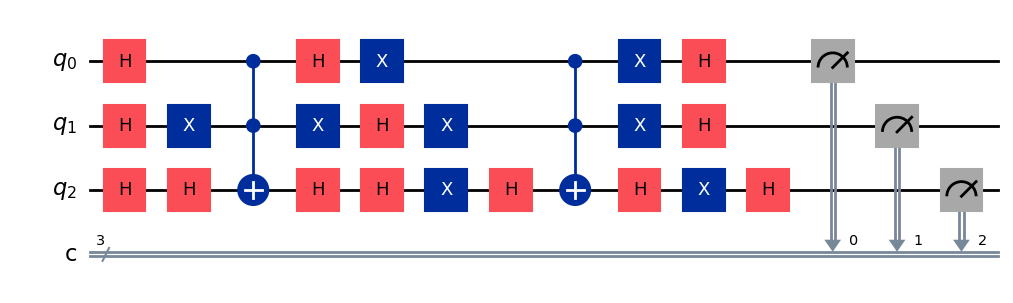

In [4]:
#task 4

marked_state = "101"
qc = grover_search(marked_state)
qc.draw('mpl')

Ideal counts: {'000': 30, '010': 33, '110': 28, '100': 42, '001': 31, '111': 40, '011': 35, '101': 785}
Noisy counts: {'110': 85, '100': 124, '011': 103, '111': 105, '001': 120, '010': 105, '000': 90, '101': 292}


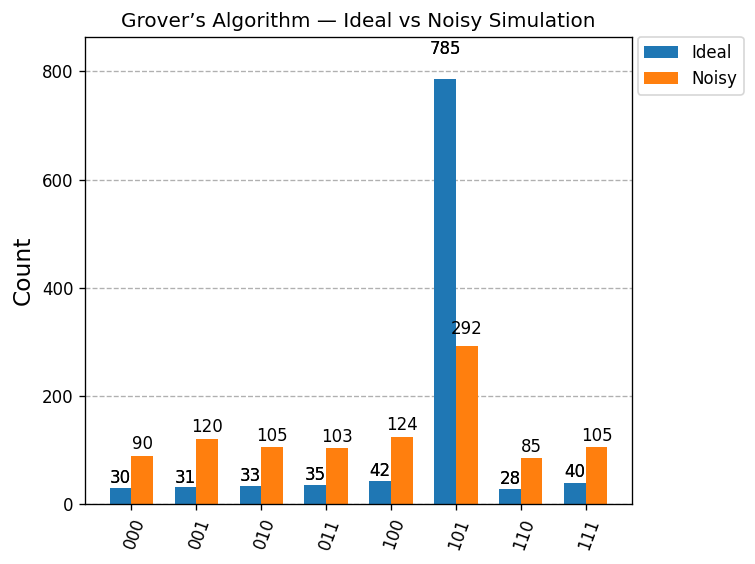

In [5]:
!pip install -q qiskit qiskit-aer matplotlib pylatexenc

# --- Imports ---
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import time

# --- Force inline plotting ---
%matplotlib inline
plt.rcParams["figure.dpi"] = 120

# --- Define Grover Circuit ---
def grover_search(marked_state: str):
    n = len(marked_state)
    qc = QuantumCircuit(n + 1, n)  # n input qubits + 1 ancilla

    # Initialize input qubits in superposition
    qc.h(range(n))

    # Prepare ancilla in |-> = H*X|0>
    qc.x(n)
    qc.h(n)
    qc.barrier()

    # Oracle (mark target state)
    for i, bit in enumerate(marked_state):
        if bit == "0":
            qc.x(i)
    qc.mcx(list(range(n)), n)  # controls = inputs, target = ancilla
    for i, bit in enumerate(marked_state):
        if bit == "0":
            qc.x(i)
    qc.barrier()

    # Diffuser (on inputs only)
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1)
    qc.h(n - 1)
    qc.x(range(n))
    qc.h(range(n))
    qc.barrier()

    # Measure inputs only
    qc.measure(range(n), range(n))
    return qc


# --- Create Noise Model ---
def create_noise_model():
    nm = NoiseModel()
    one_q = depolarizing_error(0.02, 1)
    two_q = depolarizing_error(0.05, 2)
    nm.add_all_qubit_quantum_error(one_q, ['h', 'x'])
    nm.add_all_qubit_quantum_error(two_q, ['cx'])
    return nm


# --- Run and Display Both ---
marked_state = "101"
qc = grover_search(marked_state)
ideal_sim = AerSimulator()
noise_model = create_noise_model()
noisy_sim = AerSimulator(noise_model=noise_model)

# Run ideal
res_ideal = ideal_sim.run(transpile(qc, ideal_sim), shots=1024).result()
counts_ideal = res_ideal.get_counts()
print("Ideal counts:", counts_ideal)

# Run noisy
res_noisy = noisy_sim.run(transpile(qc, noisy_sim), shots=1024).result()
counts_noisy = res_noisy.get_counts()
print("Noisy counts:", counts_noisy)

# --- Validate data ---
if not counts_ideal:
    print("⚠ No data from ideal simulator. Check backend execution.")
if not counts_noisy:
    print("⚠ No data from noisy simulator. Check noise model configuration.")

from qiskit.visualization import plot_histogram
from IPython.display import display

# --- Force render both histograms properly ---
fig = plot_histogram(
    [counts_ideal, counts_noisy],
    legend=["Ideal", "Noisy"],
    title="Grover’s Algorithm — Ideal vs Noisy Simulation"
)

# Forcefully display the Matplotlib figure in Colab
display(fig)